# MachineMax Technical Test

## Imports

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re
from Codebase.utils import generate_time_series_data
from tqdm import tqdm

## Data Generation

In [1]:
# Define machine states
STATES = ['ACTIVE', 'IDLE', 'OFF']
# Defining parameters for the time series data
start_date = '2021-01-01 00:00:00'
end_date = '2021-01-01 01:00:00'
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

# Define machine state duration boundaries (in seconds)
MIN_DURATION = 5
MAX_DURATION = 59

def generate_time_series_data(
        start_date: datetime,
        end_date: datetime,
        freq: str = '60S'
    ) -> pd.DataFrame :
    """
    Generate time series data for machine states with corresponding acceleration magnitudes.
    Args:
        start_date (datetime): Start date for the time series data.
        end_date (datetime): End date for the time series data.
        freq (str): Frequency for the time series data. Default is '1S' (i.e., one data point per second).
    Returns:
        df (pd.DataFrame): DataFrame containing the time series data.
    """
    date_range = pd.date_range(start=start_date, end=end_date, freq=freq)
    data = {'timestamp': date_range}
    df = pd.DataFrame(data)

    states = []
    rms_values = []
    current_step = 0

    pbar = tqdm(total=len(date_range), desc="Generating Data", ncols=80)

    while current_step < len(date_range):
        current_state = random.choice(STATES)
        interval = random.randint(MIN_DURATION, MAX_DURATION)

        # Calculate number of steps according to the frequency
        steps_per_second = pd.Timedelta("1s") / pd.Timedelta(freq)
        steps = int(interval * steps_per_second)

        if current_step + steps > len(date_range):
            steps = len(date_range) - current_step

        for _ in range(steps):
            current_rms = 0 if current_state == 'OFF' else (random.uniform(1, 300) if current_state == 'IDLE' else random.uniform(301, 600))
            rms_values.append(current_rms)
            states.append(current_state)

        current_step += steps
        pbar.update(steps)  # Update the progress bar

    pbar.close()

    df['state'] = states
    df['rms'] = rms_values
    
    return df


In [3]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from tqdm import tqdm  # Import TQDM

@dataclass
class TimeSeriesDataGenerator:
    STATES = ['ACTIVE', 'IDLE', 'OFF']
    MIN_DURATION = 5
    MAX_DURATION = 60
    RMS_RANGES = {'OFF': (0, 0), 'IDLE': (1, 300), 'ACTIVE': (301, 600)}

    def __init__(self, start_date: datetime, end_date: datetime, freq: str = '10S'):
        self.start_date = start_date
        self.end_date = end_date
        self.freq = freq
        self.date_range = pd.date_range(start=self.start_date, end=self.end_date, freq=self.freq)
        self.steps_per_second = pd.Timedelta("1s") / pd.Timedelta(self.freq)

    def generate_state(self) -> str:
        return random.choice(self.STATES)

    def calculate_rms(self, state) -> int:
        return random.uniform(*self.RMS_RANGES[state])

    def calculate_steps(self, interval) -> int:
        return int(interval * self.steps_per_second)

    def update_progress_bar(self, pbar, steps) -> None:
        pbar.update(steps)

    def append_generated_data(
        self,
        states: list,
        rms_values: dict,
        current_state: str,
        steps: int
    ) -> None:
        for _ in range(steps):
            current_rms = self.calculate_rms(current_state)
            rms_values.append(current_rms)
            states.append(current_state)

    @staticmethod
    def generate_time_series_data(self) -> pd.DataFrame:
        data = {'timestamp': self.date_range}
        df = pd.DataFrame(data)

        states = []
        rms_values = []
        current_step = 0

        pbar = tqdm(total=len(self.date_range), desc="Generating Data", ncols=80)

        while current_step < len(self.date_range):
            current_state = self.generate_state()
            interval = random.randint(self.MIN_DURATION, self.MAX_DURATION)

            steps = self.calculate_steps(interval)

            if current_step + steps > len(self.date_range):
                steps = len(self.date_range) - current_step

            self.append_generated_data(states, rms_values, current_state, steps)

            current_step += steps
            self.update_progress_bar(pbar, steps)

        pbar.close()

        df['state'] = states
        df['rms'] = rms_values

        return df


start_date = datetime(2021, 1, 1, 0, 0, 0)
end_date = datetime(2021, 1, 1, 1, 0, 0)

df = TimeSeriesDataGenerator.generate_time_series_data(start_date, end_date, freq='1S')

SyntaxError: expected ':' (2536962986.py, line 21)

In [2]:

# Usage
start_date = datetime.now()
end_date = start_date + timedelta(hours=1)  # Generate data for next 1 hour

df = generate_time_series_data(start_date, end_date)
print(df.head())

Generating Data: 100%|████████████████████| 361/361 [00:00<00:00, 120409.05it/s]

                   timestamp state  rms
0 2023-07-09 17:26:46.009846   OFF  0.0
1 2023-07-09 17:26:56.009846   OFF  0.0
2 2023-07-09 17:27:06.009846   OFF  0.0
3 2023-07-09 17:27:16.009846   OFF  0.0
4 2023-07-09 17:27:26.009846   OFF  0.0


### Plotting Data

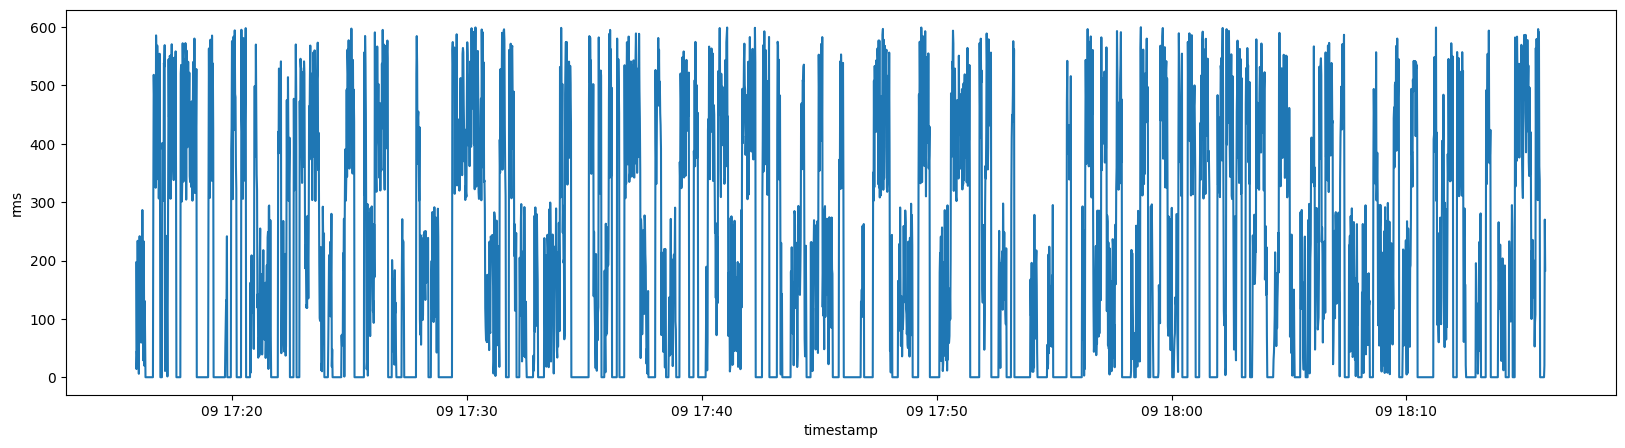

In [8]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms', data=df, ax=fig)
plt.show()

### Applying Kalman Filter

In [1]:
from pykalman import KalmanFilter

# Create a Kalman Filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=.5)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(df['rms'].values)
state_means = pd.Series(state_means.flatten(), index=df.index)

# Add the smoothed values to the DataFrame
df['rms_smoothed'] = state_means

NameError: name 'df' is not defined

In [ ]:
# Use the observations y to get a rolling mean and variance
state_means, state_covariances = kf.em(df['rms']).smooth(df['rms'])

# Add the smoothed data to the dataframe
df['rms_smoothed'] = state_means

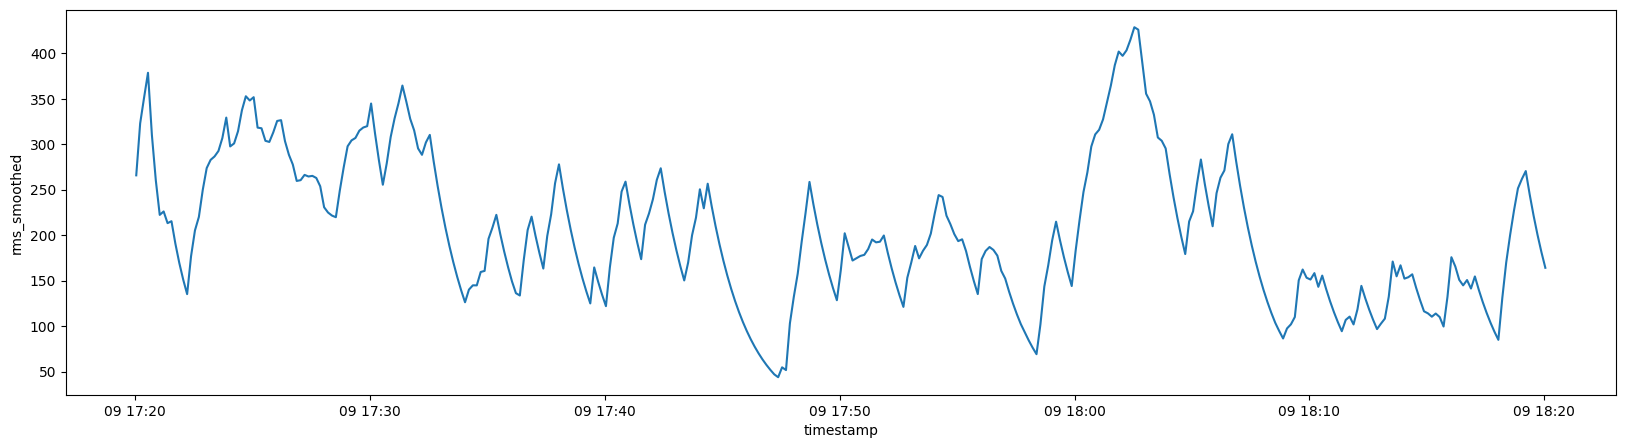

In [ ]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms_smoothed', data=df, ax=fig)
plt.show()